In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import sys
sys.path.append('..')
print(os.getcwd())

# Load utils functions
from math_trend import *
from utils import *

in_sample_start_date = '2011-01-01'
in_sample_end_date = '2016-01-01'

plt.style.use("ggplot")

# settings
data_root = '/home/jma/Python3.7/Cubist_2021_11'

dtcol = 'pos_date'
seccol = 'security_id'

/home/jma/Python3.7/Cubist_2021_11/gen_strats


In [2]:
big_df = pd.read_csv(os.path.join(data_root, 'new_processed_csvs/new_known_df_on_data_date.csv.gz'),
                    parse_dates=['data_date', 'pos_date', 'ret_date'], dtype={seccol: str},
                    usecols = ['data_date', 'pos_date', 'ret_date', seccol, 'd9', 'fwdret_f1', 'trd_price', 
                               'volume', 'in_trading_universe', 'sector', 'clip_trisk'])

assert not big_df.duplicated(subset=[dtcol, seccol]).any(), "There are duplicates!"
big_df.sort_values(by=[dtcol, seccol], inplace=True)

In [3]:
# print(big_df.head(), '\n')
print(f"big_df.tail():\n{big_df.tail()}\n\n")
print(f"big_df.shape:{big_df.shape}")

big_df.tail():
         data_date security_id     d9   pos_date   ret_date  fwdret_f1  \
5883174 2017-12-27      985601  19.27 2017-12-28 2017-12-29  -0.013173   
5883175 2017-12-27     9931801    NaN 2017-12-28 2017-12-29  -0.029629   
5883176 2017-12-27      995201   7.02 2017-12-28 2017-12-29  -0.008429   
5883177 2017-12-27     9962801    NaN 2017-12-28 2017-12-29  -0.026846   
5883178 2017-12-27      996501   0.59 2017-12-28 2017-12-29  -0.004859   

         trd_price   volume in_trading_universe                  sector  \
5883174      26.57  1182623                   Y  Consumer Discretionary   
5883175       2.70   252126                   N               Materials   
5883176      79.49   269015                   Y        Consumer Staples   
5883177       7.45    54937                   N             Health Care   
5883178     296.35  1447837                   Y             Industrials   

         clip_trisk  
5883174   30.191535  
5883175   48.236118  
5883176   24.067018  
5

In [4]:
big_df.describe()

d9     fwdret_f1     trd_price        volume    clip_trisk
count  5.220173e+06  5.882679e+06  5.883179e+06  5.883179e+06  5.621335e+06
mean   1.987257e+01  6.645949e-04  3.807288e+01  1.758139e+06  3.542353e+01
std    2.637513e+01  2.812421e-02  5.831652e+01  7.213379e+06  1.366498e+01
min    1.000000e-02 -8.761574e-01  1.000100e+00  1.000000e+02  1.350522e+01
25%    3.065000e+00 -1.043307e-02  1.228000e+01  1.790725e+05  2.441793e+01
50%    9.110000e+00  2.210900e-04  2.539000e+01  4.936090e+05  3.278926e+01
75%    2.429500e+01  1.119742e-02  4.725000e+01  1.436379e+06  4.433493e+01
max    6.802500e+03  7.208862e+00  3.525730e+03  1.864159e+09  7.500297e+01

In [5]:
big_df.loc[big_df['d9'].notnull(), 'sector'].value_counts()

Financials                941033
Information Technology    861757
Health Care               774338
Consumer Discretionary    761531
Industrials               720853
Energy                    367924
Materials                 305226
Consumer Staples          213469
Utilities                 148733
Communication Services     68329
Real Estate                56980
Name: sector, dtype: int64

In [6]:
ds_score = 'd9'

### Take out all revelant columns from the DataFrame
df = big_df.loc[:, ['pos_date', 'security_id', ds_score, 'clip_trisk', 'fwdret_f1', 'sector']].dropna(subset=[ds_score])

    pos_date security_id      d9  clip_trisk  fwdret_f1  \
0 2010-01-05     1000201  40.930         NaN   0.061447   
1 2010-01-05     1004601   4.615         NaN  -0.018519   
2 2010-01-05      100701   2.365         NaN  -0.015715   
3 2010-01-05     1007201  24.520         NaN   0.036733   
4 2010-01-05     1009601   5.545         NaN  -0.011088   

                   sector  
0  Consumer Discretionary  
1  Information Technology  
2               Utilities  
3  Consumer Discretionary  
4        Consumer Staples  


<AxesSubplot:title={'center':'Daily #Stocks in 2017'}, xlabel='pos_date'>

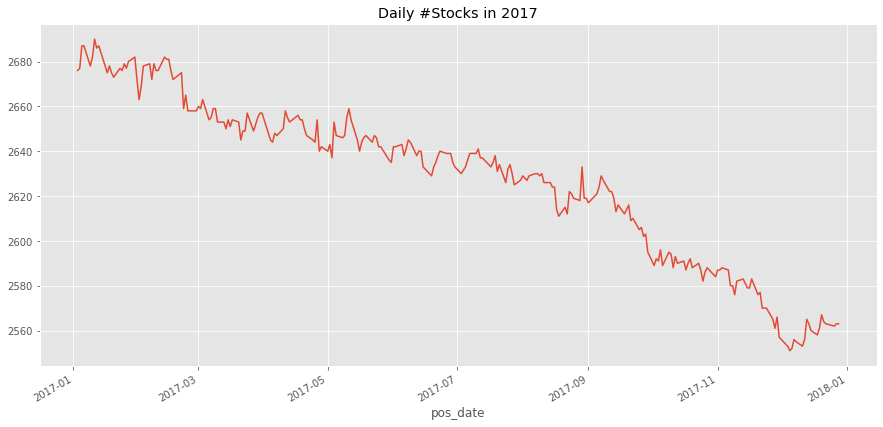

In [7]:
print(df.head())
df.loc[df['pos_date'] >= '2017-01-01'].groupby('pos_date').size().plot(title='Daily #Stocks in 2017')

Checking few examples


<AxesSubplot:xlabel='pos_date'>

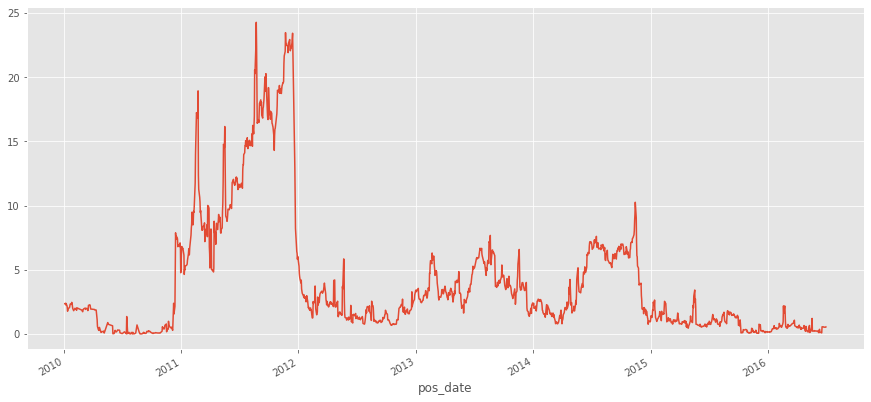

In [8]:
print("Checking few examples")
df.loc[df[seccol] == '100701'].set_index('pos_date')[ds_score].plot()

In [9]:
print("-	Values outside [0, 100] are clipped to the interval edges")
clipcol = f"clip_{ds_score}"
print(f"-	Using clipped score '{clipcol}'")
df[clipcol] = df[ds_score].clip(0, 100)

-	Values outside [0, 100] are clipped to the interval edges
-	Using clipped score 'clip_d9'


In [10]:
print(f"Percentage of stocks missing values:\n{round(df.isnull().sum() / df.shape[0] * 100, 2)}\n")
print(f"df.shape:{df.shape}")

Percentage of stocks missing values:
pos_date       0.00
security_id    0.00
d9             0.00
clip_trisk     4.27
fwdret_f1      0.00
sector         0.00
clip_d9        0.00
dtype: float64

df.shape:(5220173, 7)


In [11]:
print("Computing ztrend scores...")
df['z252'] = ztrend(df, clipcol, 252, 22, 'pos_date', seccol)
df['z126'] = ztrend(df, clipcol, 126, 22, 'pos_date', seccol)
df['z63'] = ztrend(df, clipcol, 63, 22, 'pos_date', seccol)

Computing ztrend scores...


In [12]:
print("Replace invalid values with NaNs...")
df['z252'] = df['z252'].replace([0, -np.inf, np.inf], np.nan)
df['z126'] = df['z126'].replace([0, -np.inf, np.inf], np.nan)
df['z63'] = df['z63'].replace([0, -np.inf, np.inf], np.nan)

Replace invalid values with NaNs...


In [13]:
print("Strictly only taking out daily tradable universe...")
rsch_universe = big_df.loc[big_df['in_trading_universe'] == 'Y', ['data_date', 'pos_date', seccol]].copy()

Strictly only taking out daily tradable universe...


In [14]:
rsch_universe.head()

data_date   pos_date security_id
2  2010-01-04 2010-01-05      100701
3  2010-01-04 2010-01-05     1007201
8  2010-01-04 2010-01-05     1016901
9  2010-01-04 2010-01-05     1017601
13 2010-01-04 2010-01-05    10208901

In [15]:
print("Merge alpha_df with tradeable universe")
df = df.merge(rsch_universe)

Merge alpha_df with tradeable universe


In [16]:
# df.dropna(subset=['zscore'], inplace=True)

In [17]:
for zcol in ['z63', 'z126', 'z252']:
    print(f"XS normalizing score {zcol}")
    df[f'{zcol}_score'] = wins_qnt_score(df, zcol, 'pos_date', qmin=0.05, qmax=0.95)
    df[f'{zcol}_score'] = std_qnt_score(df, f'{zcol}_score', ['sector', 'pos_date'], demean=True)
    df[f'{zcol}_score'] = df[f'{zcol}_score'].clip(-3, 3)
    df[f'{zcol}_score'] = -df[f'{zcol}_score']


XS normalizing score z63


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


XS normalizing score z126


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


XS normalizing score z252


/home/jma/miniconda3/envs/python3.7/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [18]:
print("Checking the descriptive stats and correlation of all three candidate alphas")
print(df[['z63_score', 'z126_score', 'z252_score']].describe(), "\n\n")
print(df[['z63_score', 'z126_score', 'z252_score']].corr())

Checking the descriptive stats and correlation of all three candidate alphas
          z63_score    z126_score    z252_score
count  3.511342e+06  3.519712e+06  3.523249e+06
mean   2.899747e-03  3.528278e-03  3.396718e-03
std    9.866578e-01  9.837758e-01  9.839994e-01
min   -3.000000e+00 -3.000000e+00 -3.000000e+00
25%   -6.943790e-01 -6.810051e-01 -6.621925e-01
50%    1.277295e-01  1.462058e-01  1.720193e-01
75%    7.699434e-01  7.638306e-01  7.550274e-01
max    2.393434e+00  2.210042e+00  2.257666e+00 


            z63_score  z126_score  z252_score
z63_score    1.000000    0.871289    0.699460
z126_score   0.871289    1.000000    0.875438
z252_score   0.699460    0.875438    1.000000


In [19]:
df.head()

pos_date security_id      d9  clip_trisk  fwdret_f1  \
0 2010-01-05      100701   2.365         NaN  -0.015715   
1 2010-01-05     1007201  24.520         NaN   0.036733   
2 2010-01-05     1016901  17.845         NaN   0.004698   
3 2010-01-05     1017601   2.030         NaN   0.013274   
4 2010-01-05    10208901  59.360         NaN   0.001409   

                   sector  clip_d9  z252  z126  z63  data_date  z63_score  \
0               Utilities    2.365   NaN   NaN  NaN 2010-01-04        NaN   
1  Consumer Discretionary   24.520   NaN   NaN  NaN 2010-01-04        NaN   
2              Financials   17.845   NaN   NaN  NaN 2010-01-04        NaN   
3             Health Care    2.030   NaN   NaN  NaN 2010-01-04        NaN   
4             Industrials   59.360   NaN   NaN  NaN 2010-01-04        NaN   

   z126_score  z252_score  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [20]:
# df[['pos_date', 'security_id', 'std_score']].rename(columns={'std_score': 'score9'}).to_csv(os.path.join(data_root, 'score9.csv.gz'), index=False, compression='gzip')

Taking the simple average of the three candidate alphas

Normalizing within each sector every day

Clipping the final score

Running analyzer for z63 alpha:

Running analyzer for z126 alpha:

Running analyzer for z252 alpha:

Running analyzer for simple average alpha:

z63 stats:
      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2010  0.0160  0.0082  251.0  1.9515   1573  0.2787
2011  0.0165  0.0109  252.0  1.5131   1587  0.2835
2012  0.0090  0.0086  250.0  1.0466   1523  0.2902
2013  0.0198  0.0073  252.0  2.7174   1688  0.2845
2014  0.0212  0.0089  252.0  2.3855   1927  0.2985
2015  0.0064  0.0094  252.0  0.6825   1948  0.2891
2016  0.0092  0.0092  252.0  1.0028   1914  0.2772
2017  0.0193  0.0080  250.0  2.4062   1996  0.2784

z126 stats:
      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2010  0.0164  0.0079  251.0  2.0909   1573  0.2277
2011  0.0168  0.0119  252.0  1.4091   1587 

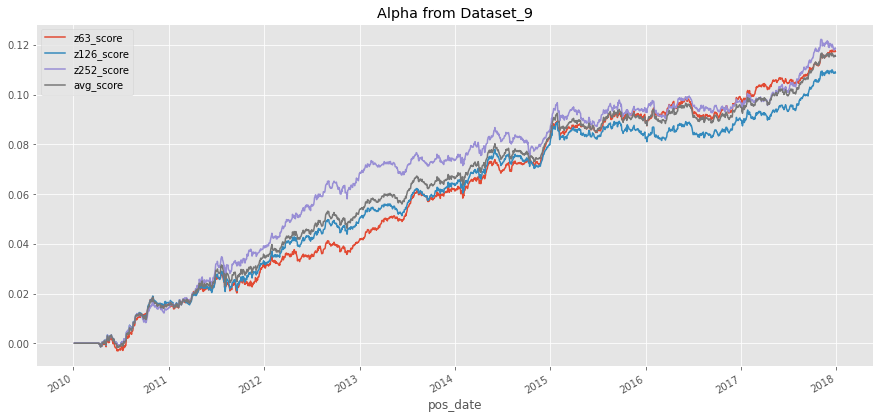

In [21]:
print("Taking the simple average of the three candidate alphas\n")
df['combined_score'] = df[['z63_score', 'z126_score', 'z252_score']].mean(axis=1)

print("Normalizing within each sector every day\n")
df['combined_score'] = std_qnt_score(df, 'combined_score', ['sector', 'pos_date'], demean=True)

print("Clipping the final score\n")
df['combined_score'] = df['combined_score'].clip(-3, 3)

print("Running analyzer for z63 alpha:\n")
daily_return_z63, ann_stats_z63 = \
    quickstats(df, 'z63_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

print("Running analyzer for z126 alpha:\n")
daily_return_z126, ann_stats_z126 = \
    quickstats(df, 'z126_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

print("Running analyzer for z252 alpha:\n")
daily_return_z252, ann_stats_z252 = \
    quickstats(df, 'z252_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
    
print("Running analyzer for simple average alpha:\n")
daily_return_avg, ann_stats_avg = \
    quickstats(df, 'combined_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

plt.title('Alpha from Dataset_9'); 
plt.legend(['z63_score', 'z126_score', 'z252_score', 'avg_score'], loc='upper left')

print(f"z63 stats:\n{ann_stats_z63}\n")
print(f"z126 stats:\n{ann_stats_z126}\n")
print(f"z252 stats:\n{ann_stats_z252}\n")
print(f"avg stats:\n{ann_stats_avg}\n")

In [22]:
print("Calc Yearly MaxDD and the Length")

print(daily_return_avg.head())
daily_return_avg['year'] = daily_return_avg['pos_date'].dt.year
print(daily_return_avg.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(daily_return_avg.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length
    pos_date  attr_fwdretf1
0 2010-01-05            0.0
1 2010-01-06            0.0
2 2010-01-07            0.0
3 2010-01-08            0.0
4 2010-01-11            0.0
      Max_Drawdown  Length
year                      
2010        -0.005    15.0
2011        -0.008    10.0
2012        -0.007    50.0
2013        -0.005    30.0
2014        -0.007   106.0
2015        -0.008   105.0
2016        -0.008    67.0
2017        -0.004    16.0 

Max Drawdown of all times:
 Max_Drawdown    -0.008
Length          10.000
dtype: float64


In [23]:
## annulized tcost in percentage 
0.20 * 252 * 0.0001

0.005040000000000001

In [24]:
print(f"Correlation matrix:\n{df[['z63_score', 'z126_score', 'z252_score', 'combined_score']].corr().round(4)}\n")
print(f"Descriptive stats:\n{df[['z63_score', 'z126_score', 'z252_score', 'combined_score']].describe()}")

Correlation matrix:
                z63_score  z126_score  z252_score  combined_score
z63_score          1.0000      0.8713      0.6995          0.9149
z126_score         0.8713      1.0000      0.8754          0.9776
z252_score         0.6995      0.8754      1.0000          0.9161
combined_score     0.9149      0.9776      0.9161          1.0000

Descriptive stats:
          z63_score    z126_score    z252_score  combined_score
count  3.511342e+06  3.519712e+06  3.523249e+06    3.523257e+06
mean   2.899747e-03  3.528278e-03  3.396718e-03    5.792347e-04
std    9.866578e-01  9.837758e-01  9.839994e-01    9.952964e-01
min   -3.000000e+00 -3.000000e+00 -3.000000e+00   -3.000000e+00
25%   -6.943790e-01 -6.810051e-01 -6.621925e-01   -6.927278e-01
50%    1.277295e-01  1.462058e-01  1.720193e-01    1.413697e-01
75%    7.699434e-01  7.638306e-01  7.550274e-01    7.816129e-01
max    2.393434e+00  2.210042e+00  2.257666e+00    2.409293e+00


<AxesSubplot:title={'center':'Daily Turnover Rate of Alpha from Dataset_9'}, xlabel='pos_date'>

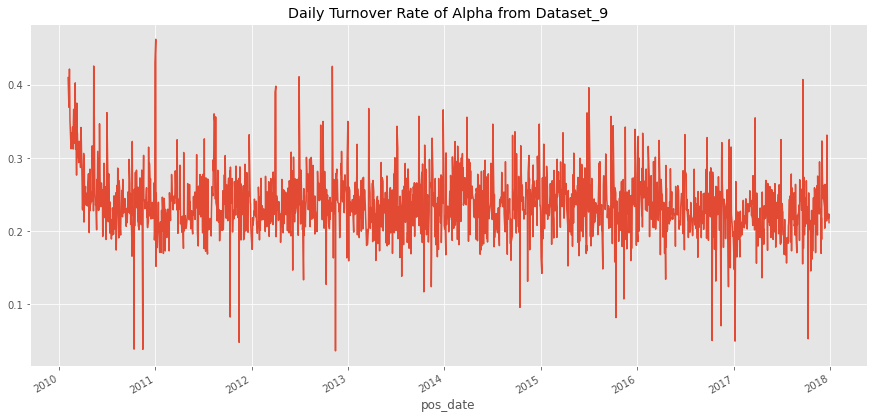

In [25]:
to = calc_daily_to(df, 'combined_score', 'pos_date', 'security_id')
to.plot(title='Daily Turnover Rate of Alpha from Dataset_9')

In [26]:
print("Compute % of positive portfolio return days for each year:")
daily_return_avg.loc[daily_return_avg['year'] >= 2011].groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year:


year
2011    55.56
2012    55.20
2013    53.57
2014    59.13
2015    54.37
2016    50.79
2017    56.00
Name: attr_fwdretf1, dtype: float64

In [27]:
"""
Considering to neutralize Alpha9 to provided risk factors

"""
### loading risk factors data
with zipfile.ZipFile(os.path.join(data_root, 'risk_factors.zip')) as zf:
    risk_factors = pd.read_csv(zf.open('risk_factors.csv'), parse_dates=['data_date'], 
                     dtype={'security_id': str, 'rf1': np.float64, 'rf2': np.float64, 'rf3': np.float64, 
                            'rf4': np.float64, 'rf5': np.float64, 'rf6': np.float64})

In [28]:
assert not risk_factors.duplicated(subset=['data_date', seccol]).any(), "There are duplicated values based on the keys"

print("Checking the data types")
print(risk_factors.dtypes)

riskfacs = ['rf1', 'rf2', 'rf3', 'rf4', 'rf5', 'rf6']

Checking the data types
data_date      datetime64[ns]
security_id            object
rf1                   float64
rf2                   float64
rf3                   float64
rf4                   float64
rf5                   float64
rf6                   float64
dtype: object


In [29]:
risk_factors[riskfacs].describe().round(2)

rf1         rf2         rf3         rf4         rf5         rf6
count  8800015.00  8800015.00  8800015.00  8800015.00  8800015.00  8800015.00
mean         0.06       -0.29        0.57        0.47       -0.01       -0.50
std          1.17        1.16        1.27        1.20        1.11        1.29
min         -3.07       -3.17       -2.89       -2.82       -2.98       -3.39
25%         -0.72       -0.90       -0.46       -0.40       -0.69       -1.14
50%          0.06       -0.21        0.26        0.28       -0.06       -0.24
75%          0.84        0.37        1.59        1.22        0.60        0.26
max          3.70        2.95        3.03        3.28        2.98        2.79

In [30]:
print("Merging risk factor df with daily tradable universe")
risk_factors = risk_factors.merge(rsch_universe)

Merging risk factor df with daily tradable universe


In [31]:
print("Merging the alphas with risk factor based on pos_date")
risk_factors = risk_factors.merge(df[['pos_date', seccol, 'combined_score', 'clip_trisk', 'fwdret_f1']])

Merging the alphas with risk factor based on pos_date


In [32]:
risk_factors = risk_factors.loc[risk_factors['pos_date'] >= '2011-01-01']
print(risk_factors.head())

        data_date security_id    rf1    rf2    rf3    rf4    rf5    rf6  \
394906 2010-12-31     2297301 -0.060  0.554  0.790 -0.133  0.634  0.028   
394907 2010-12-31     4159901  0.609 -2.354  1.092  1.901  0.826 -2.952   
394908 2010-12-31     4914901  0.696 -0.483 -0.945  1.101  0.062  0.320   
394909 2010-12-31      599401  1.189  0.168 -1.317  0.900 -0.750  0.077   
394910 2010-12-31     5779301  0.139 -0.747 -0.965  0.824 -0.065  0.069   

         pos_date  combined_score  clip_trisk  fwdret_f1  
394906 2011-01-03        0.727338   29.938564  -0.007322  
394907 2011-01-03        0.609731   49.828648   0.006712  
394908 2011-01-03        0.380008   29.468231   0.017044  
394909 2011-01-03        0.872237   35.990888   0.008866  
394910 2011-01-03       -0.980009   27.387660  -0.012987  


In [33]:
print(risk_factors[['combined_score'] + riskfacs].corr().round(4))
print(risk_factors[['combined_score'] + riskfacs].isnull().sum())

print("Dropping NaNs from alpha score column")
risk_factors.dropna(subset=['combined_score'], inplace=True)

                combined_score     rf1     rf2     rf3     rf4     rf5     rf6
combined_score          1.0000 -0.0108  0.0891 -0.0255 -0.0253 -0.0044 -0.0286
rf1                    -0.0108  1.0000 -0.0054  0.0728  0.0223  0.1036 -0.1667
rf2                     0.0891 -0.0054  1.0000 -0.0832 -0.3343  0.0460 -0.0858
rf3                    -0.0255  0.0728 -0.0832  1.0000 -0.1301  0.1841 -0.4118
rf4                    -0.0253  0.0223 -0.3343 -0.1301  1.0000 -0.2774  0.3141
rf5                    -0.0044  0.1036  0.0460  0.1841 -0.2774  1.0000 -0.0563
rf6                    -0.0286 -0.1667 -0.0858 -0.4118  0.3141 -0.0563  1.0000
combined_score    2569
rf1                  0
rf2                  0
rf3                  0
rf4                  0
rf5                  0
rf6                  0
dtype: int64
Dropping NaNs from alpha score column


In [34]:
print("Neutralizing Alpha to all 6 provided risk factors...\n")
risk_df_residual = orthogonalize(risk_factors, 'combined_score', riskfacs)

Neutralizing Alpha to all 6 provided risk factors...

Processing date 2011-01-03 00:00:00
    Fitted adjusted R^2 is 0.01569032714191987
Processing date 2011-01-04 00:00:00
    Fitted adjusted R^2 is 0.017546516719490368
Processing date 2011-01-05 00:00:00
    Fitted adjusted R^2 is 0.019118403462728195
Processing date 2011-01-06 00:00:00
    Fitted adjusted R^2 is 0.019862289573801983
Processing date 2011-01-07 00:00:00
    Fitted adjusted R^2 is 0.021382032187443833
Processing date 2011-01-10 00:00:00
    Fitted adjusted R^2 is 0.01958507449742719
Processing date 2011-01-11 00:00:00
    Fitted adjusted R^2 is 0.021176179167002096
Processing date 2011-01-12 00:00:00
    Fitted adjusted R^2 is 0.024189411311640208
Processing date 2011-01-13 00:00:00
    Fitted adjusted R^2 is 0.02615303707989236
Processing date 2011-01-14 00:00:00
    Fitted adjusted R^2 is 0.022442612770698478
Processing date 2011-01-18 00:00:00
    Fitted adjusted R^2 is 0.02845062200886206
Processing date 2011-01-19

    Fitted adjusted R^2 is 0.015935479381116502
Processing date 2011-05-25 00:00:00
    Fitted adjusted R^2 is 0.014080774540795926
Processing date 2011-05-26 00:00:00
    Fitted adjusted R^2 is 0.011947448150857576
Processing date 2011-05-27 00:00:00
    Fitted adjusted R^2 is 0.01624943639493792
Processing date 2011-05-31 00:00:00
    Fitted adjusted R^2 is 0.01334959176567796
Processing date 2011-06-01 00:00:00
    Fitted adjusted R^2 is 0.010776375144623263
Processing date 2011-06-02 00:00:00
    Fitted adjusted R^2 is 0.007520995242460082
Processing date 2011-06-03 00:00:00
    Fitted adjusted R^2 is 0.00757525959382277
Processing date 2011-06-06 00:00:00
    Fitted adjusted R^2 is 0.008445184129612593
Processing date 2011-06-07 00:00:00
    Fitted adjusted R^2 is 0.007004230177990789
Processing date 2011-06-08 00:00:00
    Fitted adjusted R^2 is 0.0074124004592074355
Processing date 2011-06-09 00:00:00
    Fitted adjusted R^2 is 0.006761504698641674
Processing date 2011-06-10 00:

    Fitted adjusted R^2 is 0.002055403121658861
Processing date 2011-10-14 00:00:00
    Fitted adjusted R^2 is 0.005214176693326356
Processing date 2011-10-17 00:00:00
    Fitted adjusted R^2 is 0.008080959391282283
Processing date 2011-10-18 00:00:00
    Fitted adjusted R^2 is 0.006751474968198279
Processing date 2011-10-19 00:00:00
    Fitted adjusted R^2 is 0.016888976262803945
Processing date 2011-10-20 00:00:00
    Fitted adjusted R^2 is 0.012196550224136349
Processing date 2011-10-21 00:00:00
    Fitted adjusted R^2 is 0.01538362589453246
Processing date 2011-10-24 00:00:00
    Fitted adjusted R^2 is 0.015578556930082144
Processing date 2011-10-25 00:00:00
    Fitted adjusted R^2 is 0.011715056843416893
Processing date 2011-10-26 00:00:00
    Fitted adjusted R^2 is 0.013943700500635203
Processing date 2011-10-27 00:00:00
    Fitted adjusted R^2 is 0.014766303282314874
Processing date 2011-10-28 00:00:00
    Fitted adjusted R^2 is 0.01372592868958833
Processing date 2011-10-31 00:

    Fitted adjusted R^2 is 0.035113062856703015
Processing date 2012-03-08 00:00:00
    Fitted adjusted R^2 is 0.03409901445334129
Processing date 2012-03-09 00:00:00
    Fitted adjusted R^2 is 0.03899943893481084
Processing date 2012-03-12 00:00:00
    Fitted adjusted R^2 is 0.04048771266721207
Processing date 2012-03-13 00:00:00
    Fitted adjusted R^2 is 0.03690940997562675
Processing date 2012-03-14 00:00:00
    Fitted adjusted R^2 is 0.03686824405957678
Processing date 2012-03-15 00:00:00
    Fitted adjusted R^2 is 0.03590924305133125
Processing date 2012-03-16 00:00:00
    Fitted adjusted R^2 is 0.032265350778369006
Processing date 2012-03-19 00:00:00
    Fitted adjusted R^2 is 0.0345056666400918
Processing date 2012-03-20 00:00:00
    Fitted adjusted R^2 is 0.036616791906286195
Processing date 2012-03-21 00:00:00
    Fitted adjusted R^2 is 0.03403366072208569
Processing date 2012-03-22 00:00:00
    Fitted adjusted R^2 is 0.028985202458648107
Processing date 2012-03-23 00:00:00
 

    Fitted adjusted R^2 is 0.011410072097106538
Processing date 2012-07-27 00:00:00
    Fitted adjusted R^2 is 0.013810522313054463
Processing date 2012-07-30 00:00:00
    Fitted adjusted R^2 is 0.01570429265435125
Processing date 2012-07-31 00:00:00
    Fitted adjusted R^2 is 0.017125100216566547
Processing date 2012-08-01 00:00:00
    Fitted adjusted R^2 is 0.017086281619767663
Processing date 2012-08-02 00:00:00
    Fitted adjusted R^2 is 0.016058376919404704
Processing date 2012-08-03 00:00:00
    Fitted adjusted R^2 is 0.012153577806619409
Processing date 2012-08-06 00:00:00
    Fitted adjusted R^2 is 0.010683986989984628
Processing date 2012-08-07 00:00:00
    Fitted adjusted R^2 is 0.008188878443762926
Processing date 2012-08-08 00:00:00
    Fitted adjusted R^2 is 0.0070344190989510835
Processing date 2012-08-09 00:00:00
    Fitted adjusted R^2 is 0.010739544934464718
Processing date 2012-08-10 00:00:00
    Fitted adjusted R^2 is 0.008846251414319828
Processing date 2012-08-13 0

    Fitted adjusted R^2 is 0.0020695556221894673
Processing date 2012-12-20 00:00:00
    Fitted adjusted R^2 is 0.002623515321787173
Processing date 2012-12-21 00:00:00
    Fitted adjusted R^2 is 0.0003208020646490173
Processing date 2012-12-24 00:00:00
    Fitted adjusted R^2 is 0.0014142420197966743
Processing date 2012-12-26 00:00:00
    Fitted adjusted R^2 is 0.001367503022674632
Processing date 2012-12-27 00:00:00
    Fitted adjusted R^2 is 0.0024947271778558155
Processing date 2012-12-28 00:00:00
    Fitted adjusted R^2 is 0.0056449777067856255
Processing date 2012-12-31 00:00:00
    Fitted adjusted R^2 is 0.0042119051463026524
Processing date 2013-01-02 00:00:00
    Fitted adjusted R^2 is 0.002993539433688519
Processing date 2013-01-03 00:00:00
    Fitted adjusted R^2 is 0.006211995388927027
Processing date 2013-01-04 00:00:00
    Fitted adjusted R^2 is 0.003727207769505858
Processing date 2013-01-07 00:00:00
    Fitted adjusted R^2 is 0.004548630179442292
Processing date 2013-0

    Fitted adjusted R^2 is 0.021729627945381247
Processing date 2013-05-16 00:00:00
    Fitted adjusted R^2 is 0.017980138334027007
Processing date 2013-05-17 00:00:00
    Fitted adjusted R^2 is 0.015912886551527228
Processing date 2013-05-20 00:00:00
    Fitted adjusted R^2 is 0.014537252314324567
Processing date 2013-05-21 00:00:00
    Fitted adjusted R^2 is 0.01607044354664644
Processing date 2013-05-22 00:00:00
    Fitted adjusted R^2 is 0.017336257267351773
Processing date 2013-05-23 00:00:00
    Fitted adjusted R^2 is 0.01861298507959852
Processing date 2013-05-24 00:00:00
    Fitted adjusted R^2 is 0.02107571041156564
Processing date 2013-05-28 00:00:00
    Fitted adjusted R^2 is 0.0261739398671077
Processing date 2013-05-29 00:00:00
    Fitted adjusted R^2 is 0.02579946305890246
Processing date 2013-05-30 00:00:00
    Fitted adjusted R^2 is 0.026203977065737405
Processing date 2013-05-31 00:00:00
    Fitted adjusted R^2 is 0.030010552632855125
Processing date 2013-06-03 00:00:0

    Fitted adjusted R^2 is 0.010498866834528386
Processing date 2013-10-10 00:00:00
    Fitted adjusted R^2 is 0.007703865149099043
Processing date 2013-10-11 00:00:00
    Fitted adjusted R^2 is 0.007196679523666538
Processing date 2013-10-14 00:00:00
    Fitted adjusted R^2 is 0.007501167890587301
Processing date 2013-10-15 00:00:00
    Fitted adjusted R^2 is 0.0074459888706347455
Processing date 2013-10-16 00:00:00
    Fitted adjusted R^2 is 0.006645307976938075
Processing date 2013-10-17 00:00:00
    Fitted adjusted R^2 is 0.005185007338124881
Processing date 2013-10-18 00:00:00
    Fitted adjusted R^2 is 0.00473024501644137
Processing date 2013-10-21 00:00:00
    Fitted adjusted R^2 is 0.003726657687229795
Processing date 2013-10-22 00:00:00
    Fitted adjusted R^2 is 0.0045601039527175535
Processing date 2013-10-23 00:00:00
    Fitted adjusted R^2 is 0.0021273536585473263
Processing date 2013-10-24 00:00:00
    Fitted adjusted R^2 is 0.0020368654809543862
Processing date 2013-10-2

    Fitted adjusted R^2 is 0.020626579108366738
Processing date 2014-03-04 00:00:00
    Fitted adjusted R^2 is 0.018539299849309798
Processing date 2014-03-05 00:00:00
    Fitted adjusted R^2 is 0.020011618114662788
Processing date 2014-03-06 00:00:00
    Fitted adjusted R^2 is 0.019131317930280223
Processing date 2014-03-07 00:00:00
    Fitted adjusted R^2 is 0.016108262160220876
Processing date 2014-03-10 00:00:00
    Fitted adjusted R^2 is 0.019011472078559688
Processing date 2014-03-11 00:00:00
    Fitted adjusted R^2 is 0.020724792777755185
Processing date 2014-03-12 00:00:00
    Fitted adjusted R^2 is 0.019890458773472508
Processing date 2014-03-13 00:00:00
    Fitted adjusted R^2 is 0.02183728360551407
Processing date 2014-03-14 00:00:00
    Fitted adjusted R^2 is 0.01815148622356133
Processing date 2014-03-17 00:00:00
    Fitted adjusted R^2 is 0.02178746707475865
Processing date 2014-03-18 00:00:00
    Fitted adjusted R^2 is 0.026562186166759538
Processing date 2014-03-19 00:0

    Fitted adjusted R^2 is 0.018203901838243386
Processing date 2014-07-24 00:00:00
    Fitted adjusted R^2 is 0.01751883892778161
Processing date 2014-07-25 00:00:00
    Fitted adjusted R^2 is 0.019835825688042208
Processing date 2014-07-28 00:00:00
    Fitted adjusted R^2 is 0.022141846752459893
Processing date 2014-07-29 00:00:00
    Fitted adjusted R^2 is 0.021739791477278336
Processing date 2014-07-30 00:00:00
    Fitted adjusted R^2 is 0.02259952882891869
Processing date 2014-07-31 00:00:00
    Fitted adjusted R^2 is 0.02128843763174637
Processing date 2014-08-01 00:00:00
    Fitted adjusted R^2 is 0.021141260559039865
Processing date 2014-08-04 00:00:00
    Fitted adjusted R^2 is 0.01748933577414924
Processing date 2014-08-05 00:00:00
    Fitted adjusted R^2 is 0.013188920971518914
Processing date 2014-08-06 00:00:00
    Fitted adjusted R^2 is 0.012769497924512208
Processing date 2014-08-07 00:00:00
    Fitted adjusted R^2 is 0.014815749788430699
Processing date 2014-08-08 00:00

    Fitted adjusted R^2 is 0.01105340598631066
Processing date 2014-12-16 00:00:00
    Fitted adjusted R^2 is 0.010233285037203665
Processing date 2014-12-17 00:00:00
    Fitted adjusted R^2 is 0.012959051215639672
Processing date 2014-12-18 00:00:00
    Fitted adjusted R^2 is 0.012630740389119377
Processing date 2014-12-19 00:00:00
    Fitted adjusted R^2 is 0.013069736431817303
Processing date 2014-12-22 00:00:00
    Fitted adjusted R^2 is 0.010835622486107255
Processing date 2014-12-23 00:00:00
    Fitted adjusted R^2 is 0.010168270405660151
Processing date 2014-12-24 00:00:00
    Fitted adjusted R^2 is 0.009764573043066771
Processing date 2014-12-26 00:00:00
    Fitted adjusted R^2 is 0.006490884327486901
Processing date 2014-12-29 00:00:00
    Fitted adjusted R^2 is 0.008837556583104034
Processing date 2014-12-30 00:00:00
    Fitted adjusted R^2 is 0.006020217363079117
Processing date 2014-12-31 00:00:00
    Fitted adjusted R^2 is 0.004548218584533581
Processing date 2015-01-02 00

    Fitted adjusted R^2 is 0.008093121163099681
Processing date 2015-05-18 00:00:00
    Fitted adjusted R^2 is 0.006548233714681828
Processing date 2015-05-19 00:00:00
    Fitted adjusted R^2 is 0.00637382874737058
Processing date 2015-05-20 00:00:00
    Fitted adjusted R^2 is 0.005329191318676818
Processing date 2015-05-21 00:00:00
    Fitted adjusted R^2 is 0.002688463039054123
Processing date 2015-05-22 00:00:00
    Fitted adjusted R^2 is 0.0014651714186267872
Processing date 2015-05-26 00:00:00
    Fitted adjusted R^2 is 0.002935015391860585
Processing date 2015-05-27 00:00:00
    Fitted adjusted R^2 is 0.005152565544424337
Processing date 2015-05-28 00:00:00
    Fitted adjusted R^2 is 0.00640470604758514
Processing date 2015-05-29 00:00:00
    Fitted adjusted R^2 is 0.0074894192583064845
Processing date 2015-06-01 00:00:00
    Fitted adjusted R^2 is 0.008890796249811483
Processing date 2015-06-02 00:00:00
    Fitted adjusted R^2 is 0.010650671033120784
Processing date 2015-06-03 0

    Fitted adjusted R^2 is 0.0013036957256841175
Processing date 2015-10-14 00:00:00
    Fitted adjusted R^2 is 0.0019721228711010452
Processing date 2015-10-15 00:00:00
    Fitted adjusted R^2 is 0.0028388943404534794
Processing date 2015-10-16 00:00:00
    Fitted adjusted R^2 is 0.0019038809955622682
Processing date 2015-10-19 00:00:00
    Fitted adjusted R^2 is 0.0019978174244700275
Processing date 2015-10-20 00:00:00
    Fitted adjusted R^2 is 0.0023771307320595847
Processing date 2015-10-21 00:00:00
    Fitted adjusted R^2 is 0.001521332697875355
Processing date 2015-10-22 00:00:00
    Fitted adjusted R^2 is 0.002583626596387112
Processing date 2015-10-23 00:00:00
    Fitted adjusted R^2 is 0.0015636208470354296
Processing date 2015-10-26 00:00:00
    Fitted adjusted R^2 is 0.0003860144282538114
Processing date 2015-10-27 00:00:00
    Fitted adjusted R^2 is 0.0016409868105728975
Processing date 2015-10-28 00:00:00
    Fitted adjusted R^2 is 0.00293855386414954
Processing date 2015

    Fitted adjusted R^2 is 0.0120812056637154
Processing date 2016-03-11 00:00:00
    Fitted adjusted R^2 is 0.012629058485799649
Processing date 2016-03-14 00:00:00
    Fitted adjusted R^2 is 0.01089074033751991
Processing date 2016-03-15 00:00:00
    Fitted adjusted R^2 is 0.007763088158054154
Processing date 2016-03-16 00:00:00
    Fitted adjusted R^2 is 0.005358445981001991
Processing date 2016-03-17 00:00:00
    Fitted adjusted R^2 is 0.008363768145586148
Processing date 2016-03-18 00:00:00
    Fitted adjusted R^2 is 0.006661816607447468
Processing date 2016-03-21 00:00:00
    Fitted adjusted R^2 is 0.00836244519139151
Processing date 2016-03-22 00:00:00
    Fitted adjusted R^2 is 0.006070761111138578
Processing date 2016-03-23 00:00:00
    Fitted adjusted R^2 is 0.005712909884132755
Processing date 2016-03-24 00:00:00
    Fitted adjusted R^2 is 0.009450726643006724
Processing date 2016-03-28 00:00:00
    Fitted adjusted R^2 is 0.007759895257522742
Processing date 2016-03-29 00:00

    Fitted adjusted R^2 is 0.015299479736785804
Processing date 2016-08-04 00:00:00
    Fitted adjusted R^2 is 0.010464499670948535
Processing date 2016-08-05 00:00:00
    Fitted adjusted R^2 is 0.010819502286836147
Processing date 2016-08-08 00:00:00
    Fitted adjusted R^2 is 0.01215488411488741
Processing date 2016-08-09 00:00:00
    Fitted adjusted R^2 is 0.012033514251421074
Processing date 2016-08-10 00:00:00
    Fitted adjusted R^2 is 0.015355153903751306
Processing date 2016-08-11 00:00:00
    Fitted adjusted R^2 is 0.014857273045143726
Processing date 2016-08-12 00:00:00
    Fitted adjusted R^2 is 0.014472963975891484
Processing date 2016-08-15 00:00:00
    Fitted adjusted R^2 is 0.016574953368825085
Processing date 2016-08-16 00:00:00
    Fitted adjusted R^2 is 0.015388202000167106
Processing date 2016-08-17 00:00:00
    Fitted adjusted R^2 is 0.01067638796856396
Processing date 2016-08-18 00:00:00
    Fitted adjusted R^2 is 0.009241313113943272
Processing date 2016-08-19 00:

    Fitted adjusted R^2 is 0.022437805247834564
Processing date 2016-12-28 00:00:00
    Fitted adjusted R^2 is 0.02205881673225929
Processing date 2016-12-29 00:00:00
    Fitted adjusted R^2 is 0.02212952352155151
Processing date 2016-12-30 00:00:00
    Fitted adjusted R^2 is 0.02369908382728214
Processing date 2017-01-03 00:00:00
    Fitted adjusted R^2 is 0.024807104339112263
Processing date 2017-01-04 00:00:00
    Fitted adjusted R^2 is 0.0268147387505705
Processing date 2017-01-05 00:00:00
    Fitted adjusted R^2 is 0.03034080207270251
Processing date 2017-01-06 00:00:00
    Fitted adjusted R^2 is 0.029267365359620934
Processing date 2017-01-09 00:00:00
    Fitted adjusted R^2 is 0.02746578445040715
Processing date 2017-01-10 00:00:00
    Fitted adjusted R^2 is 0.02907557614723366
Processing date 2017-01-11 00:00:00
    Fitted adjusted R^2 is 0.034098957228364424
Processing date 2017-01-12 00:00:00
    Fitted adjusted R^2 is 0.030353482947227617
Processing date 2017-01-13 00:00:00


    Fitted adjusted R^2 is 0.01968438174435394
Processing date 2017-05-26 00:00:00
    Fitted adjusted R^2 is 0.018603013682283676
Processing date 2017-05-30 00:00:00
    Fitted adjusted R^2 is 0.02082173808604104
Processing date 2017-05-31 00:00:00
    Fitted adjusted R^2 is 0.019456319202516226
Processing date 2017-06-01 00:00:00
    Fitted adjusted R^2 is 0.020924585718598565
Processing date 2017-06-02 00:00:00
    Fitted adjusted R^2 is 0.020043424822166367
Processing date 2017-06-05 00:00:00
    Fitted adjusted R^2 is 0.02446521466111984
Processing date 2017-06-06 00:00:00
    Fitted adjusted R^2 is 0.021377904217110832
Processing date 2017-06-07 00:00:00
    Fitted adjusted R^2 is 0.018052736537237046
Processing date 2017-06-08 00:00:00
    Fitted adjusted R^2 is 0.017847708170432908
Processing date 2017-06-09 00:00:00
    Fitted adjusted R^2 is 0.020115595029775224
Processing date 2017-06-12 00:00:00
    Fitted adjusted R^2 is 0.02293118321535781
Processing date 2017-06-13 00:00

    Fitted adjusted R^2 is 0.027588111752847477
Processing date 2017-10-19 00:00:00
    Fitted adjusted R^2 is 0.027433015871755173
Processing date 2017-10-20 00:00:00
    Fitted adjusted R^2 is 0.025312200392539785
Processing date 2017-10-23 00:00:00
    Fitted adjusted R^2 is 0.02617009567527684
Processing date 2017-10-24 00:00:00
    Fitted adjusted R^2 is 0.027206197897851503
Processing date 2017-10-25 00:00:00
    Fitted adjusted R^2 is 0.024783308898980172
Processing date 2017-10-26 00:00:00
    Fitted adjusted R^2 is 0.025713560056164875
Processing date 2017-10-27 00:00:00
    Fitted adjusted R^2 is 0.025405093180905225
Processing date 2017-10-30 00:00:00
    Fitted adjusted R^2 is 0.02701299447679073
Processing date 2017-10-31 00:00:00
    Fitted adjusted R^2 is 0.02230795475926073
Processing date 2017-11-01 00:00:00
    Fitted adjusted R^2 is 0.020486548704373164
Processing date 2017-11-02 00:00:00
    Fitted adjusted R^2 is 0.01832608365579702
Processing date 2017-11-03 00:00

In [35]:
(risk_df_residual).head()

data_date security_id    rf1    rf2    rf3    rf4    rf5    rf6  \
394906 2010-12-31     2297301 -0.060  0.554  0.790 -0.133  0.634  0.028   
394907 2010-12-31     4159901  0.609 -2.354  1.092  1.901  0.826 -2.952   
394908 2010-12-31     4914901  0.696 -0.483 -0.945  1.101  0.062  0.320   
394909 2010-12-31      599401  1.189  0.168 -1.317  0.900 -0.750  0.077   
394910 2010-12-31     5779301  0.139 -0.747 -0.965  0.824 -0.065  0.069   

         pos_date  combined_score  clip_trisk  fwdret_f1     Resid  
394906 2011-01-03        0.727338   29.938564  -0.007322  0.748112  
394907 2011-01-03        0.609731   49.828648   0.006712  0.890475  
394908 2011-01-03        0.380008   29.468231   0.017044  0.386355  
394909 2011-01-03        0.872237   35.990888   0.008866  0.750221  
394910 2011-01-03       -0.980009   27.387660  -0.012987 -0.948564

In [36]:
print("Computing loading correlation between the ones with and w/o neutralization")
risk_df_residual[['combined_score', 'Resid']].corr().round(4)

Computing loading correlation between the ones with and w/o neutralization


combined_score   Resid
combined_score          1.0000  0.9914
Resid                   0.9914  1.0000

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0202  0.0117  252.0  1.7248   1585  0.2352
2012  0.0177  0.0091  250.0  1.9523   1523  0.2396
2013  0.0126  0.0075  252.0  1.6735   1686  0.2331
2014  0.0170  0.0097  252.0  1.7471   1926  0.2445
2015  0.0053  0.0103  252.0  0.5116   1947  0.2393
2016  0.0064  0.0091  252.0  0.7088   1912  0.2297
2017  0.0206  0.0092  250.0  2.2475   1994  0.2269 

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0207  0.0108  252.0  1.9220   1585  0.2380
2012  0.0106  0.0078  250.0  1.3556   1523  0.2442
2013  0.0056  0.0072  252.0  0.7804   1686  0.2374
2014  0.0135  0.0088  252.0  1.5424   1926  0.2483
2015  0.0038  0.0085  252.0  0.4426   1947  0.2420
2016  0.0036  0.0087  252.0  0.4140   1912  0.2324
2017  0.0144  0.0068  250.0  2.1077   1994  0.2313 



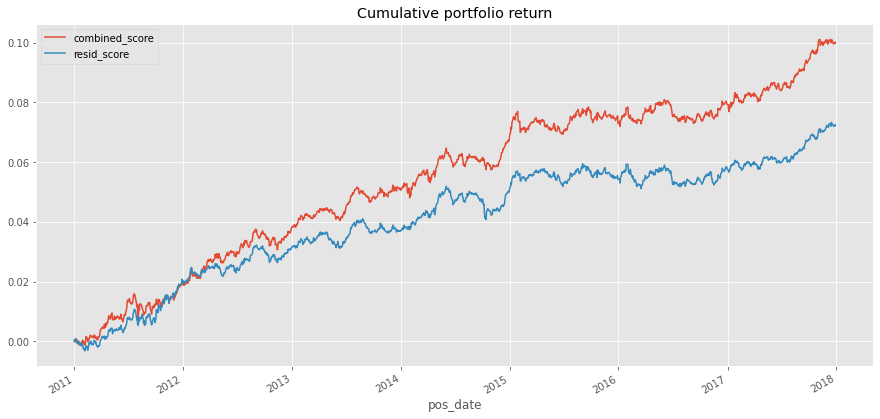

In [37]:
daily_return_raw, stats1 = quickstats(risk_df_residual, 'combined_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
daily_return_resid, stats2 = quickstats(risk_df_residual, 'Resid', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

plt.legend(['combined_score', 'resid_score'], loc='upper left')

print(stats1, '\n')
print(stats2, '\n')

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011 -0.0649  0.1150  252.0 -0.5644   1585  0.1234
2012 -0.0849  0.0486  250.0 -1.7463   1523  0.1143
2013 -0.1140  0.0607  252.0 -1.8785   1686  0.1177
2014 -0.0675  0.0530  252.0 -1.2745   1926  0.1534
2015 -0.0094  0.0727  252.0 -0.1291   1947  0.1531
2016 -0.1169  0.0720  252.0 -1.6251   1912  0.1340
2017 -0.0641  0.0474  250.0 -1.3517   1994  0.1148


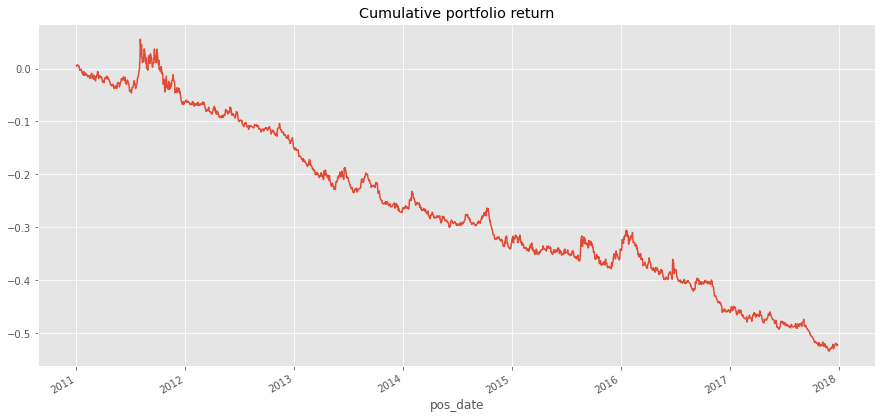

In [38]:
daily_return_rf3, stats3 = quickstats(risk_df_residual, 'rf3', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(stats3)

In [39]:
print("Calc Yearly MaxDD and the Length of the neutralized version\n\n")

print(daily_return_resid.head())
daily_return_resid['year'] = daily_return_resid['pos_date'].dt.year
print(daily_return_resid.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(daily_return_resid.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length of the neutralized version


    pos_date  attr_fwdretf1
0 2011-01-03       0.000478
1 2011-01-04      -0.000573
2 2011-01-05       0.000460
3 2011-01-06       0.000154
4 2011-01-07       0.000365
      Max_Drawdown  Length
year                      
2011        -0.005    24.0
2012        -0.006    48.0
2013        -0.005    46.0
2014        -0.011    93.0
2015        -0.006    44.0
2016        -0.008    35.0
2017        -0.003    16.0 

Max Drawdown of all times:
 Max_Drawdown    -0.011
Length          93.000
dtype: float64


In [40]:
print("Compute % of positive portfolio return days for each year:")
daily_return_resid.loc[daily_return_resid['year'] >= 2011].groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year:


year
2011    56.35
2012    54.40
2013    51.59
2014    55.95
2015    50.00
2016    49.21
2017    53.20
Name: attr_fwdretf1, dtype: float64

In [48]:
alpha9 = df.loc[df['pos_date'] >= '2011-01-01', 
                ['pos_date', 'security_id', 'clip_trisk', 'fwdret_f1', 'sector', 'z63_score', 'z126_score', 'z252_score', 'combined_score']]

In [49]:
alpha9.head()

pos_date security_id  clip_trisk  fwdret_f1                  sector  \
394906 2011-01-03     1004601   62.162621  -0.020927  Information Technology   
394907 2011-01-03      100701   19.749199  -0.009325               Utilities   
394908 2011-01-03     1007201   37.389405  -0.011587  Consumer Discretionary   
394909 2011-01-03     1009601   29.017306  -0.029014        Consumer Staples   
394910 2011-01-03    10116101   55.507777   0.007392             Industrials   

        z63_score  z126_score  z252_score  combined_score  
394906  -0.200387   -0.753759   -1.287964       -0.804733  
394907  -1.366048   -1.875685   -2.133090       -1.926442  
394908  -2.183436   -1.776859   -1.988166       -2.124544  
394909  -0.902751   -0.622103   -0.795166       -0.858331  
394910  -1.498729   -0.220915   -0.013842       -0.622511

In [50]:
alpha9.to_csv(os.path.join(data_root, 'new_processed_csvs/new_alpha9.csv.gz'), index=False, compression='gzip')